In [25]:
import numpy as np
from synthesizer.photoionisation import cloudy23
import matplotlib.pyplot as plt
import cmasher as cmr
from astropy.io import ascii
from synthesizer.sed import Sed
from unyt import cm, erg, Angstrom, pc, s, h, c

In [26]:

# log10hydrogen_densities = np.array([8.])
log10hydrogen_densities = np.arange(3.,13.,1.)

stopping_column_densities = 10**np.arange(21., 25., 0.5) * cm**-2

final_model = len(stopping_column_densities)

colours = cmr.take_cmap_colors('cmr.ember', len(log10hydrogen_densities), cmap_range=(0.1, 0.9))

## HII Ionisation structure

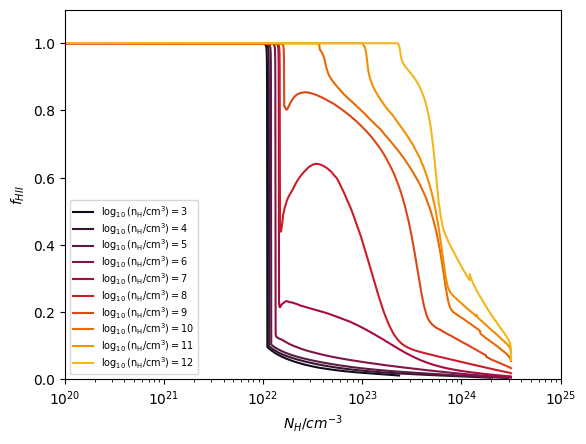

In [34]:

zone = 'HII'

fig, ax = plt.subplots()

for log10hydrogen_density, colour in zip(log10hydrogen_densities,colours):

    data = ascii.read(f'hden:{log10hydrogen_density}/{final_model}.ovr')
    depth = data['depth'] * cm
    hydrogen_density = 10**log10hydrogen_density * cm**-3
    column_density = depth * hydrogen_density 

    label = rf'$\rm \log_{{10}}(n_{{H}}/cm^{{3}})={log10hydrogen_density:.0f}$'

    ax.plot(column_density.to('cm**-2').value, data[zone], c=colour, label=label)
        
ax.legend(fontsize=7., labelspacing=0.1)
ax.set_xscale('log')
ax.set_xlabel('$N_{H}/cm^{-2}$')
ax.set_ylabel('$f_{HII}$')
ax.set_xlim(1E21, 1E25)
ax.set_ylim(0.0, 1.1)
plt.show()

## H-alpha luminosity / ionising photon luminosity

In [30]:
case_b = (1.08E-53 / 7.9E-42) # erg

print(case_b)

1.3670886075949369e-12


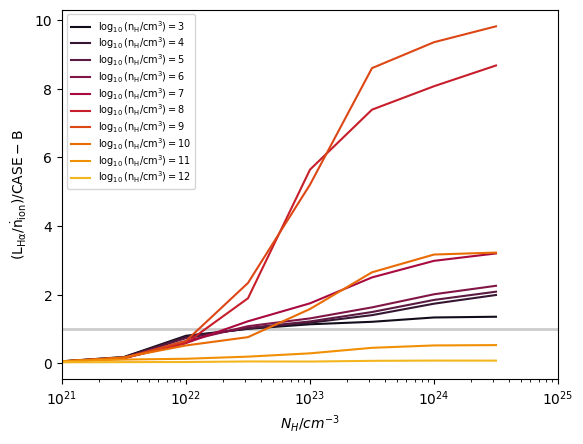

In [44]:

extension = 'emergent_elin'

fig, ax = plt.subplots()

ax.axhline(1.0, c='k', lw=2, alpha=0.2)

for log10hydrogen_density, colour in zip(log10hydrogen_densities,colours):

    halpha_ratio = []

    for i, stopping_column_density in enumerate(stopping_column_densities):

        # get the output incident spectra 
        lam_, incident = np.loadtxt(f"hden:{log10hydrogen_density}/{i+1}.cont", delimiter="\t", usecols=(0, 1)).T
        lam = lam_[::-1] * Angstrom
        nu = c / lam
        incident_lnu = incident[::-1] * (erg / s) / nu / 1E7
        sed = Sed(lam=lam, lnu=incident_lnu)
        bolometric_luminosity = sed.bolometric_luminosity
        ionising_photon_luminosity = sed.calculate_ionising_photon_production_rate()

        # get tuple of line_id, wavelength, and line luminosity
        linelist = cloudy23.read_linelist(f'hden:{log10hydrogen_density}/{i+1}', extension=extension)

        # convert tuple of arrays into a dictionary
        line_luminosity = dict(zip(linelist[0], linelist[2]))

        # take ratio and append to list
        halpha_ratio.append(line_luminosity['H 1 6562.80A']/ionising_photon_luminosity.to('1/s').value)

    label = rf'$\rm \log_{{10}}(n_{{H}}/cm^{{3}})={log10hydrogen_density:.0f}$'

    ax.plot(stopping_column_densities.to('cm**-2').value, np.array(halpha_ratio)/case_b, c=colour, label=label)



ax.legend(fontsize=7., labelspacing=0.1)
ax.set_xscale('log')
ax.set_xlabel('$N_{H}/cm^{-3}$')
ax.set_ylabel(r'$\rm (L_{H\alpha}/\dot{n}_{ion})/CASE-B$')
ax.set_xlim(1E21, 1E25)
# ax.set_ylim(0.0, 1.1)
plt.show()

## Balmer Decrement

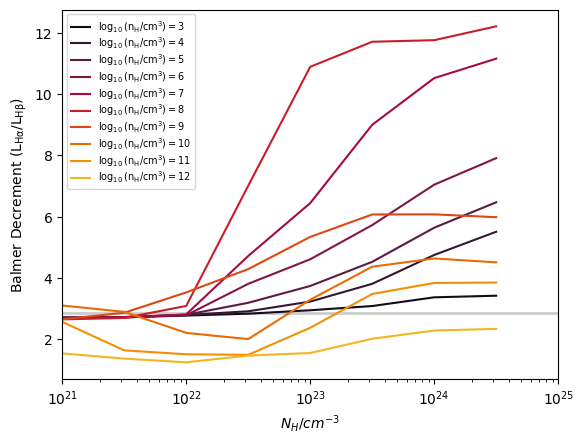

In [43]:
extension = 'intrinsic_elin'

fig, ax = plt.subplots()

ax.axhline(2.86, c='k', lw=2, alpha=0.2)

for log10hydrogen_density, colour in zip(log10hydrogen_densities,colours):

    balmer_decrement = []

    for i, stopping_column_density in enumerate(stopping_column_densities):

        # get tuple of line_id, wavelength, and line luminosity
        linelist = cloudy23.read_linelist(f'hden:{log10hydrogen_density}/{i+1}', extension=extension)

        # convert tuple of arrays into a dictionary
        line_luminosity = dict(zip(linelist[0], linelist[2]))

        # take ratio and append to list
        balmer_decrement.append(line_luminosity['H 1 6562.80A']/line_luminosity['H 1 4861.32A'])

    label = rf'$\rm \log_{{10}}(n_{{H}}/cm^{{3}})={log10hydrogen_density:.0f}$'

    ax.plot(stopping_column_densities.to('cm**-2').value, np.array(balmer_decrement), c=colour, label=label)



ax.legend(fontsize=7., labelspacing=0.1)
ax.set_xscale('log')
ax.set_xlabel('$N_{H}/cm^{-3}$')
ax.set_ylabel(r'$\rm Balmer\ Decrement\ (L_{H\alpha}/L_{H\beta})$')
ax.set_xlim(1E21, 1E25)
# ax.set_ylim(0.0, 1.1)
plt.show()
